In [2]:
import csv

def find_missing_numbers(input_csv, output_csv):
    # Read the integers from the input CSV
    with open(input_csv, 'r') as file:
        reader = csv.reader(file)
        #next(reader, None)  # Skip header
        numbers = [int(row[0]) for row in reader]

    # Find the missing numbers
    full_set = set(range(1, 19016))
    missing_numbers = sorted(list(full_set - set(numbers)))

    # Write the missing numbers to the output CSV
    with open(output_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        #writer.writerow(['Missing Numbers'])  # Header
        for number in missing_numbers:
            writer.writerow([number])

# Example usage
input_csv = 'data/USC/train.csv'  # Replace with your input CSV file path
output_csv = 'data/USC/test.csv'  # The output file will be created with this name
find_missing_numbers(input_csv, output_csv)


In [15]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install scikit-image
!pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     ------------------------------------- 160.4/160.4 kB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.6 MB 21.6 MB/s eta 0:00:01
   ----------- ---------------------------- 2.2/7.6 MB 23.5 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 26.7 MB/s eta 0:00:01
   ----------------------------- ---------- 5.6/7.6 MB 29.8 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 32.2 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 28.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.6 kB ? eta -:--:--
   --------------------------------------- 187.6/187.6 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------  2.2/2.2 MB 46.0 MB/s eta 0:00:01
   ----------------


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import zipfile
with zipfile.ZipFile('data/USC/Rx.zip', 'r') as zip_ref:
    zip_ref.extractall('../tmp')

In [84]:
%autoreload 2

from dataloader.loader_USC import PMnet_usc

usc_training_data=PMnet_usc('data/USC/train.csv', 'data/USC')
print(f"Number of samples in the training dataset: {len(usc_training_data)}")

usc_test_data=PMnet_usc('data/USC/test.csv', 'data/USC')
print(f"Number of samples in the test dataset: {len(usc_test_data)}")

from torch.utils.data import DataLoader

usc_training_dataloader = DataLoader(usc_training_data, batch_size=16, shuffle=True)
usc_test_dataloader = DataLoader(usc_test_data, batch_size=16, shuffle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of samples in the training dataset: 15211
Number of samples in the test dataset: 3803


Sample image shape: torch.Size([2, 256, 256]), Sample label: torch.Size([1, 256, 256])


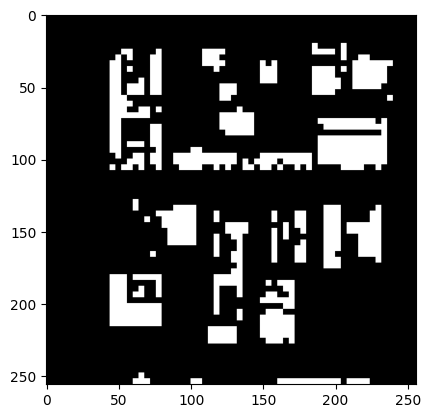

Feature batch shape: torch.Size([16, 2, 256, 256])
Labels batch shape: torch.Size([16, 1, 256, 256])


In [106]:
image, label = usc_training_data[0]  # Get the first sample
print(f"Sample image shape: {image.shape}, Sample label: {label.shape}")

import matplotlib.pyplot as plt

img_4_show = image[0,:,:].unsqueeze(0).permute(1,2,0)

plt.imshow(img_4_show.squeeze(), cmap='gray')
plt.show()

train_features, train_labels = next(iter(usc_training_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

In [88]:
from network.PMNet import PMNet
network = PMNet([3,3,3,3], [1,1,1], None, 16)
print(network)

PMNet(
  (layer1): _Stem(
    (conv1): _ConvBnReLU(
      (conv): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=True)
  )
  (layer2): _ResLayer(
    (block1): _Bottleneck(
      (reduce): _ConvBnReLU(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv3x3): _ConvBnReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.0010000000000000009, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (increase): _ConvBnReLU(
        (conv): Conv2d(64, 256, 

In [89]:
import torch.optim as optim

optimizer = optim.Adam(network.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=10, gamma=0.5)

In [110]:
from evaluation.eval import ROI_RMSE_Loss

loss_fn = ROI_RMSE_Loss()

In [113]:
import torch.nn as nn

for epoch in range(1,2):
    network.train()
    for batch_idx, (data, target) in enumerate(usc_training_dataloader):
        optimizer.zero_grad()
        output = network(data)    
        roi = data[:, 0, :, :].unsqueeze(1)
        target_with_roi = torch.cat((target, roi), dim=1)
        loss = loss_fn(output,target_with_roi)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(usc_training_dataloader.sampler),
                    100.0 * batch_idx / len(usc_training_dataloader),
                    loss.item(),
                )
            )

ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [0/15211 (0%)] Loss: 0.517527
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [16/15211 (0%)] Loss: 0.416127
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [32/15211 (0%)] Loss: 0.387073
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [48/15211 (0%)] Loss: 0.391319
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [64/15211 (0%)] Loss: 0.396915
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [80/15211 (1%)] Loss: 0.386089
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [96/15211 

KeyboardInterrupt: 